# Data Source and goal of this case study

Data: https://www.kaggle.com/patrickb1912/ipl-complete-dataset-20082020  
          
Goal:   
    1. Identify cluster of players with similar performance  
    2. Given a player name, identify similar players  
    3. Create a best team with mix of batsman, bowler, allrounders & wicket-keeper
    

# Imports and data read

In [465]:
import pandas as pd
import matplotlib.pyplot  as plt

import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.cluster import DBSCAN

In [466]:
balldf = pd.read_csv("data/IPL_2008_2020/IPL Ball-by-Ball 2008-2020.csv")

In [467]:
matches = pd.read_csv("data/IPL_2008_2020/IPL Matches 2008-2020.csv")

In [468]:
balldf.head(3)

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


In [469]:
matches.head(3)

,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
0,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,Chandigarh,2008-04-19,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,N,NaN,MR Benson,SL Shastri
2,335984,Delhi,2008-04-19,MF Maharoof,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,N,NaN,Aleem Dar,GA Pratapkumar


In [470]:
balldf.shape

(193468, 18)

In [471]:
matches.shape

(816, 17)

# Check Missing

In [472]:
balldf.isnull().sum()

id                       0
inning                   0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
batsman_runs             0
extra_runs               0
total_runs               0
non_boundary             0
is_wicket                0
dismissal_kind      183973
player_dismissed    183973
fielder             186684
extras_type         183235
batting_team             0
bowling_team           191
dtype: int64

The variables with missing data is not used to create the player statistics in this analysis and can be ignored.

# Create batsman statistics

## Variables by grouping on batsman

In [473]:
# Group details on batsmen
batgroup = balldf.groupby(['batsman'])

# Create a batting dataframe with a summary statistics for each batsman
batdf = pd.DataFrame(batgroup['ball'].count()).rename(columns={'ball':'balls_faced'})
batdf['innings'] = batgroup['id'].nunique()
batdf['runs'] = batgroup['batsman_runs'].sum()
batdf['4s'] = balldf[balldf['batsman_runs'] == 4].groupby('batsman')['batsman_runs'].count()
batdf['4s'].fillna(0,inplace=True)
batdf['6s'] = balldf[balldf['batsman_runs'] == 6].groupby('batsman')['batsman_runs'].count()
batdf['6s'].fillna(0,inplace=True)


## Derived variable - Batsman average & strike rate

In [474]:
# Batting average = total rus scored/no. of times batsman is been dismissed
# Approximated here to matches instead of no. of dismissals
batdf['bat_average'] = round(batdf['runs']/batdf['innings'],2)

In [475]:
# Strike Rate = (Runs Scored / Balls faced) * 100
batdf['bat_strike'] = round(batdf['runs']/batdf['balls_faced']*100,2)


In [476]:
display(batdf.tail())

,balls_faced,innings,runs,4s,6s,bat_average,bat_strike
batsman,,,,,,,
YV Takawale,183,10,192,26.0,3.0,19.20,104.92
Yashpal Singh,67,4,47,5.0,0.0,11.75,70.15
Younis Khan,7,1,3,0.0,0.0,3.00,42.86
Yuvraj Singh,2205,126,2750,217.0,149.0,21.83,124.72
Z Khan,141,27,117,11.0,2.0,4.33,82.98


# Create bowler statistics

## Variables by grouping on bowler

In [477]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [478]:
# Group details on bowler
bowlgroup = balldf.groupby(['bowler'])

# Create a bowling dataframe (bowldf) with a summary statistics for each batsman
bowldf = pd.DataFrame(bowlgroup['ball'].count()).rename(columns={'ball':'balls_bowled'})

# Get no. of wickets taken by each bowler
bwl_wkts = balldf[balldf['dismissal_kind'].isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket'])]
bowldf['wickets'] = bwl_wkts.groupby(['bowler'])['ball'].count()
bowldf['wickets'].fillna(0,inplace=True)
 
# Calculate the total no. of overs bowled
overs = pd.DataFrame(balldf.groupby(['bowler','id'])['over'].nunique())
bowldf['overs'] = overs.groupby(['bowler'])['over'].sum()    

# Calculate the runs conceded
bowldf['runs_conceded'] = balldf.groupby('bowler')['batsman_runs'].sum()
bowldf['runs_conceded'] = bowldf['runs_conceded'].fillna(0)
# Add the runs conceded through wide and noball
bowldf['runs_conceded'] = bowldf['runs_conceded'].add(balldf[balldf['extras_type'].isin(['wides','noballs'])].groupby('bowler')['extra_runs'].sum(),fill_value=0)

bowldf.head()


,balls_bowled,wickets,overs,runs_conceded
bowler,,,,
A Ashish Reddy,270,18.0,45,396.0
A Chandila,234,11.0,39,242.0
A Choudhary,108,5.0,17,144.0
A Dananjaya,25,0.0,4,47.0
A Flintoff,66,2.0,11,105.0


## Derived variable - Bowler econ rate

In [479]:
# Note - roughly apprx to overs.  Should be runs_conceded/overs.balls
bowldf['bowl_econ'] = round(bowldf['runs_conceded']/bowldf['overs'],2)

In [480]:
display(bowldf.tail())

,balls_bowled,wickets,overs,runs_conceded,bowl_econ
bowler,,,,,
YA Abdulla,222,15.0,35,307.0,8.77
YK Pathan,1184,42.0,193,1415.0,7.33
YS Chahal,2188,121.0,359,2723.0,7.58
Yuvraj Singh,882,36.0,146,1077.0,7.38
Z Khan,2276,102.0,371,2782.0,7.50


# Get all players list along with the matches count

Getting total no. of matches:  
- If the player's name occurs as batsman, non-striker or bowler consider the player has played that match  
- Note: this is a rough approximation for the matches played (there could be players who have played in the match but did not get a chance to bat or bowl in the match)


In [481]:
def update_player_with_match(player_name, id):
    if player_name in all_players_dict:
        all_players_dict[player_name].add(id)
    else:
        all_players_dict[player_name] = {id}
    
def update_player_list(x):
    update_player_with_match(x['batsman'],x['id'])
    update_player_with_match(x['non_striker'],x['id'])
    update_player_with_match(x['bowler'],x['id']) 
        


In [482]:
all_players_dict = {}
out_temp = balldf.apply(lambda x: update_player_list(x),axis=1)
all_df = pd.DataFrame({'Players':list(all_players_dict.keys())})
all_df['matches'] = all_df['Players'].apply(lambda x: len(all_players_dict[x]))
all_df=all_df.set_index('Players')

# Merged player statistics

In [483]:
# Combine the batting and bowling dataframes to create a merged players dataframe
players = pd.merge(all_df,batdf, left_index=True, right_index=True,how='outer')
players = pd.merge(players,bowldf, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

In [484]:
players.tail()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ
YV Takawale,10,183.0,10.0,192.0,26.0,3.0,19.20,104.92,0.0,0.0,0.0,0.0,0.00
Yashpal Singh,4,67.0,4.0,47.0,5.0,0.0,11.75,70.15,0.0,0.0,0.0,0.0,0.00
Younis Khan,1,7.0,1.0,3.0,0.0,0.0,3.00,42.86,0.0,0.0,0.0,0.0,0.00
Yuvraj Singh,129,2205.0,126.0,2750.0,217.0,149.0,21.83,124.72,882.0,36.0,146.0,1077.0,7.38
Z Khan,99,141.0,27.0,117.0,11.0,2.0,4.33,82.98,2276.0,102.0,371.0,2782.0,7.50


# Create no. of catches statistics

In [485]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [486]:
# Total catches = Number of caught & bowled + number of catches as fielder
# Capture caught & bowled instances
catches_cb = balldf[(balldf['dismissal_kind'].isin(['caught and bowled']))].groupby('bowler')['ball'].count().rename('bowler_catches')
# Capture the catches
catches_c = balldf[(balldf['dismissal_kind'].isin(['caught']))].groupby('fielder')['ball'].count().rename('fielder_catches')
# Combine the caught & bowled and fielding catches to get the total catches.
catches_df = pd.merge(catches_cb,catches_c, left_index=True, right_index=True,how='outer')
catches_df.fillna(0,inplace=True)
catches_df['catches'] = catches_df['bowler_catches']+catches_df['fielder_catches']
catches_df.drop(['bowler_catches','fielder_catches'],axis=1,inplace=True)
# Merge total catches to players data
players = pd.merge(players,catches_df, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

# Number of man of the  matches from matches file

In [487]:
players = pd.merge(players,matches['player_of_match'].value_counts(), left_index=True, right_index=True,how='left')
players['player_of_match']  = players[['player_of_match']].fillna(0)

In [488]:
players.head()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Chandila,12.0,7.0,2.0,4.0,0.0,0.0,2.00,57.14,234.0,11.0,39.0,242.0,6.21,7.0,1.0
A Chopra,6.0,75.0,6.0,53.0,7.0,0.0,8.83,70.67,0.0,0.0,0.0,0.0,0.00,2.0,0.0
A Choudhary,5.0,20.0,3.0,25.0,1.0,1.0,8.33,125.00,108.0,5.0,17.0,144.0,8.47,0.0,0.0
A Dananjaya,1.0,5.0,1.0,4.0,0.0,0.0,4.00,80.00,25.0,0.0,4.0,47.0,11.75,0.0,0.0


# Filtering: Remove players who have played less matches

In [489]:
# Backup before data filtering
all_players = players.copy()

ALL_COLUMN_NAMES = list(players.columns)

In [490]:
players.shape

(648, 15)

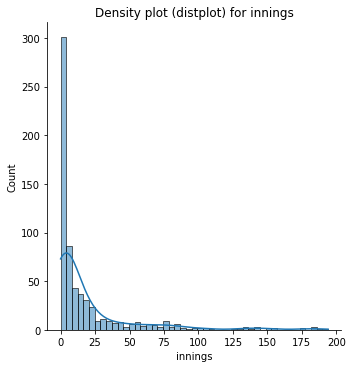

In [491]:
sns.displot(players['innings'],kde=True)
plt.title('Density plot (distplot) for innings')
plt.show()

In [492]:
players['innings'].describe()

count    648.000000
mean      18.768519
std       32.885716
min        0.000000
25%        1.000000
50%        5.000000
75%       19.000000
max      194.000000
Name: innings, dtype: float64

In [493]:
# Cut off on no. of matches

# Current Analysis: Players who have played atleast 10 matches
CUTOFF_MATCHES = 10
players=players[players['innings']>=CUTOFF_MATCHES]

In [494]:
players.shape

(251, 15)

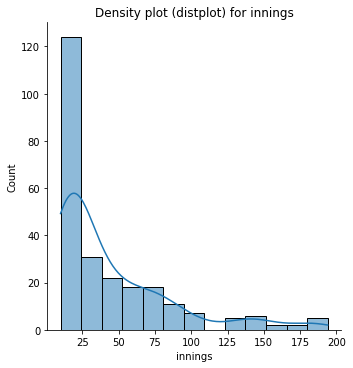

In [495]:
sns.displot(players['innings'],kde=True)
plt.title('Density plot (distplot) for innings')
plt.show()

# Explore the players data

In [496]:
players.head()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Kumble,42.0,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0
A Mishra,150.0,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3233.0,160.0,529.0,3867.0,7.31,21.0,11.0
A Nehra,88.0,63.0,17.0,41.0,3.0,1.0,2.41,65.08,1974.0,106.0,320.0,2495.0,7.80,19.0,6.0
A Symonds,36.0,781.0,36.0,974.0,74.0,41.0,27.06,124.71,540.0,20.0,88.0,674.0,7.66,21.0,3.0


<function matplotlib.pyplot.show(*args, **kw)>

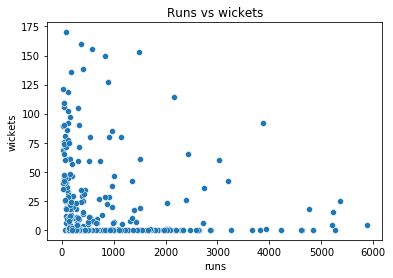

In [497]:
sns.scatterplot(data=players, x="runs", y="wickets")
plt.title("Runs vs wickets")
plt.show

# Scale the data

In [498]:
# Standard Scaler (mean = 0 and standard deviation = 1)
scaler = StandardScaler()

# fit_transform
players_scaled = pd.DataFrame(scaler.fit_transform(players),columns=players.columns)
players_scaled.shape
players_scaled.head()


# TESTING -  CONSIDER  ONLY RUNS AND WICKETS
#players_scaled  = players_scaled[['runs','wickets','catches']]

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
0,-0.681449,-0.586132,-0.514618,-0.537008,-0.596562,-0.394531,-0.476250,1.197842,-0.400299,-0.220922,-0.391620,-0.353023,0.772222,-0.561588,-0.755049
1,-0.363228,-0.746431,-0.707912,-0.743238,-0.710905,-0.698918,-1.604319,-2.082638,0.495151,0.507283,0.520538,0.320197,0.193070,-0.513659,0.003020
2,2.091618,-0.352772,0.234399,-0.467985,-0.482219,-0.597456,-1.103337,-1.308329,3.320906,3.608900,3.349777,3.176804,0.398656,0.013558,2.024537
3,0.682355,-0.731164,-0.659589,-0.738188,-0.710905,-0.678626,-1.595148,-2.374267,1.739740,2.152489,1.734173,1.781551,0.521507,-0.082300,0.761089
4,-0.499608,0.051791,-0.200514,0.047168,-0.086415,0.133073,1.230758,0.364289,-0.061208,-0.166981,-0.059223,-0.070311,0.486407,0.013558,0.003020


In [499]:
# Mean around ~0 and standard deviation ~1 in all the scaled columns
players_scaled.describe()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
count,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02
mean,-1.415424e-17,5.661695e-17,-3.538559e-18,-4.246271e-17,2.830848e-17,7.607903e-17,7.430975e-17,-1.698509e-16,5.750159e-17,-2.476992e-17,-1.769280e-17,-5.307839e-18,-7.784831e-17,4.157807e-17,5.130911e-17
std,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00
min,-1.090590e+00,-7.551544e-01,-8.287215e-01,-7.592314e-01,-7.372922e-01,-6.989182e-01,-1.775134e+00,-3.729996e+00,-7.393897e-01,-7.063928e-01,-7.394775e-01,-7.557342e-01,-1.434069e+00,-9.929471e-01,-7.550485e-01
25%,-8.178293e-01,-6.493792e-01,-6.837506e-01,-6.380189e-01,-6.405401e-01,-5.974558e-01,-7.892201e-01,-5.174868e-01,-7.393897e-01,-7.063928e-01,-7.394775e-01,-7.557342e-01,-1.434069e+00,-6.574456e-01,-6.287037e-01
50%,-3.177680e-01,-4.498239e-01,-4.662942e-01,-4.570419e-01,-4.558316e-01,-3.945310e-01,-1.518151e-01,1.461410e-01,-4.392317e-01,-4.906282e-01,-4.380013e-01,-4.313278e-01,4.462923e-01,-3.219440e-01,-2.496694e-01
75%,5.346092e-01,2.279009e-01,4.035312e-01,2.723374e-01,1.730569e-01,1.432196e-01,7.045546e-01,6.393841e-01,4.078669e-01,3.724304e-01,4.007210e-01,3.766374e-01,6.368355e-01,2.292371e-01,2.557098e-01
max,3.114471e+00,4.226096e+00,3.617053e+00,4.175127e+00,4.460933e+00,6.383156e+00,2.441369e+00,2.536119e+00,3.594691e+00,3.878606e+00,3.612602e+00,3.579515e+00,3.580227e+00,4.662650e+00,5.056812e+00


# update player name as column

In [500]:
players.insert(0, 'name', players.index)

In [501]:
players.head()

,name,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
A Ashish Reddy,A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Kumble,A Kumble,42.0,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0
A Mishra,A Mishra,150.0,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3233.0,160.0,529.0,3867.0,7.31,21.0,11.0
A Nehra,A Nehra,88.0,63.0,17.0,41.0,3.0,1.0,2.41,65.08,1974.0,106.0,320.0,2495.0,7.80,19.0,6.0
A Symonds,A Symonds,36.0,781.0,36.0,974.0,74.0,41.0,27.06,124.71,540.0,20.0,88.0,674.0,7.66,21.0,3.0


# Finding optimal no. of clusters (k)

## Elbow method

Steps in elbow method:
- Initialize k with a range of values for the no. of clusters.   
- For each value of k, 
    - perform the k-means clustering  
    - compute the sum of squared distances of samples to the nearest cluster centre
- Plot a graph of k versus the sum of squared distances


In [571]:
def elbow_plot(min_k, max_k, k_max_iter):
    # Elbow-curve/sum of squared distances
    sum_squared_distances = []
    k_range = range(min_k, max_k+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=k_max_iter)
        kmeans.fit(players_scaled)

        sum_squared_distances.append(kmeans.inertia_)

    # plot the SSDs for each k

    plt.plot(k_range, sum_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

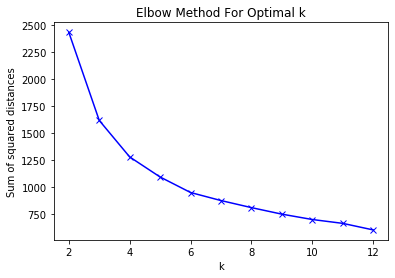

In [573]:
elbow_plot(2,12, 50)


Inference:
- As the no. of clusters (k) increases, the sum of squared distance tends to zero.   
- The plot of no. of clusters vs sum of squared distances will look like an arm. The elbow on the arm is optimal k.
- In the plot for the players dataset, the elbow is at k=5 indicating the optimal k for this dataset is 5

## Silhouette Analysis¶
silhouette score=(𝑝−𝑞)/𝑚𝑎𝑥(𝑝,𝑞)
 
𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of

𝑞  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [575]:
def compute_silhouette_score(min_k, max_k, k_max_iter):
    # silhouette analysis
    k_range = range(min_k, max_k+1)

    for k in k_range :
        # intialise kmeans
        kmeans = KMeans(n_clusters=k, max_iter=k_max_iter)
        kmeans.fit(players_scaled)
        cluster_labels = kmeans.labels_

        # silhouette score
        silhouette_avg = silhouette_score(players_scaled, cluster_labels)
        print(f"For k={k}, silhouette score = {silhouette_avg}")

In [576]:
compute_silhouette_score(2,12,50)

For k=2, silhouette score = 0.42070575402411103
For k=3, silhouette score = 0.4059024385404374
For k=4, silhouette score = 0.3658360748244456
For k=5, silhouette score = 0.306839667868035
For k=6, silhouette score = 0.30021355807939354
For k=7, silhouette score = 0.29549538553120797
For k=8, silhouette score = 0.27912004786649314
For k=9, silhouette score = 0.2868295609663751
For k=10, silhouette score = 0.28692681375276696
For k=11, silhouette score = 0.2709083150187935
For k=12, silhouette score = 0.2755835863161546


Inference:
- The best possible silhouette score is around 0.42
- The optimal no. of clusters could be 4 or 5

In [507]:
NUM_CLUSTERS = 5

# Utility Methods

In [508]:
players.head(2)

,name,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
A Ashish Reddy,A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Kumble,A Kumble,42.0,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0


In [509]:
# Initialize few colour codes for each cluster
CLUSTER_COLORS = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#BDA589','#888C46',
                  '#36688D','#00743F','#0444BF','#A7414A','#1D65A6','red','green','blue','orange','pink','yellow']

In [510]:
# Show the top few players in each cluster (Players sorted on no. of matches played)
def  groupby_cluster(cluster_col, head_size):
    g = players.groupby([cluster_col]).apply(lambda x: x.sort_values(["matches"], ascending = False)).reset_index(drop=True)
    # select top N rows within each cluster
    display(g.groupby(cluster_col)['name',cluster_col].head(head_size))

In [511]:

def print_with_column_color_style(input_df):

    col_bgcolor_dict = dict(zip(input_df.columns,['background-color:'+i for i in CLUSTER_COLORS]))
    def mycolor(x):
        return pd.DataFrame(col_bgcolor_dict,index=x.index,columns=x.columns)

    return input_df.style.apply(mycolor,axis=None)

In [512]:

def print_with_row_color_style(input_df, cluster_col):
    clusters = list(input_df[cluster_col].sort_values().unique())
    col_bgcolor_dict = dict(zip(clusters,['background-color:'+i for i in CLUSTER_COLORS]))
    def mycolor(x):
        return [col_bgcolor_dict[x[cluster_col]]]*len(x)
    
    return input_df.style.apply(mycolor,axis=1)

In [513]:
# Get the summary of the clustering based on the labels in the output column specified
def  clustering_summary(cluster_col):
    
    # Create summary table for clusters
    cluster_summary = pd.DataFrame(players[cluster_col].value_counts().sort_index())
    cluster_summary.columns = ['Num_Players']
    cluster_summary.insert(0, 'Cluster', cluster_summary.index)
    
    # Plot pie-chart
    fig = plt.figure(figsize=(15,6))

    ax1 = fig.add_subplot(121)
    cluster_summary['Num_Players'].plot.pie(autopct="%1.1f%%",  colors = CLUSTER_COLORS)
    
    print("\n-----------------------\nPLAYERS CLUSTER SUMMARY\n-----------------------\n")
    
    # Plot summary table

    #display(cluster_summary)
    ax2 = fig.add_subplot(122)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    
    # Set the row colours to match the cluster index
    colors = []
    num_columns = len(cluster_summary.columns)
    num_rows = len(cluster_summary.index)
    for i in range(num_rows):
        colors.append([CLUSTER_COLORS[i]] * num_columns)

    summary_plot_table = ax2.table(cellText=cluster_summary.values,cellColours=colors,
                         colLabels=cluster_summary.columns,bbox=bbox,loc='center',cellLoc='center' )

    summary_plot_table.auto_set_font_size(False)
    summary_plot_table.set_fontsize(font_size)

    plt.show()


#     # Sort players data based on no. of innings played
#     #players.sort_values(["innings"], ascending = False,inplace=True)
#     # Create column for each cluster and insert players in that cluster
#     grouper = players.sort_values(["innings"], ascending = False)[['name',cluster_col]].groupby([cluster_col])
#     cluster_df = pd.concat([pd.Series(v['name'].tolist(), name=k) for k, v in grouper], axis=1)
#     cluster_df.fillna('',inplace=True)
#     print("\n-----------------------\nPLAYERS IN EACH CLUSTER\n-----------------------\n")
#     display(print_with_column_color_style(cluster_df))
    
#     return cluster_summary, cluster_df

In [514]:
# Get the summary of the clustering based on the labels in the output column specified
def  clustering_data(cluster_col):
    

    # Sort players data based on no. of innings played
    #players.sort_values(["innings"], ascending = False,inplace=True)
    # Create column for each cluster and insert players in that cluster
    grouper = players.sort_values(["innings"], ascending = False)[['name',cluster_col]].groupby([cluster_col])
    cluster_df = pd.concat([pd.Series(v['name'].tolist(), name=k) for k, v in grouper], axis=1)
    cluster_df.fillna('',inplace=True)
    print("\n-----------------------\nPLAYERS IN EACH CLUSTER\n-----------------------\n")
    display(print_with_column_color_style(cluster_df))
    
    #return cluster_summary, cluster_df

In [515]:
# Get the summary of the clustering based on the labels in the output column specified
def  cluster_all_stats(cluster_col): 
    display(print_with_row_color_style(players[CLUSTER_COLS+[cluster_col]],cluster_col))
    

In [516]:
CLUSTER_COLS + ["try1"]

['matches',
 'balls_faced',
 'innings',
 'runs',
 '4s',
 '6s',
 'bat_average',
 'bat_strike',
 'balls_bowled',
 'wickets',
 'overs',
 'runs_conceded',
 'bowl_econ',
 'catches',
 'player_of_match',
 'try1']

# k-means Clustering

In [517]:
# Define function to perform the kmeans clustering on the given data
def kmeans_clustering(num_clusters, max_iterations,input_df,output_df, output_col):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=max_iterations)
    kmeans.fit(input_df)
    # assign the label to the output column
    output_df[output_col] = kmeans.labels_ 

In [518]:
# New output column to create for the cluster label
kmeans_label = 'cluster_kmeans'

# K-means clustering
kmeans_clustering(NUM_CLUSTERS,50,players_scaled[ALL_COLUMN_NAMES],players,kmeans_label)

# View few entries from each cluster
groupby_cluster(kmeans_label,3)


,name,cluster_kmeans
0,STR Binny,0
1,KH Pandya,0
2,KV Sharma,0
105,KM Jadhav,1
106,SS Tiwary,1
107,S Badrinath,1
155,RG Sharma,2
156,SK Raina,2
157,V Kohli,2
171,RA Jadeja,3



-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



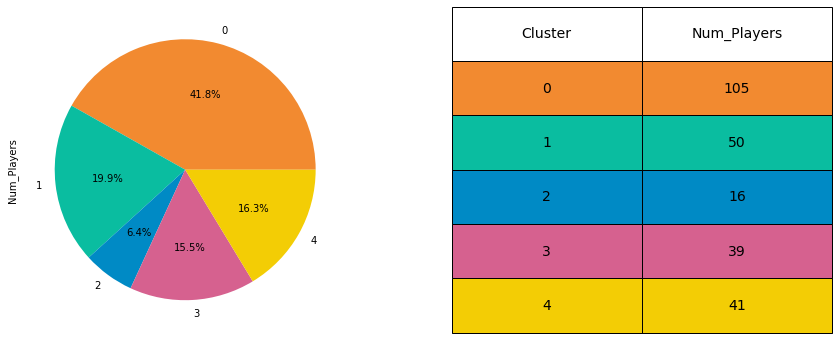

In [519]:

# View the summary of the clustering
clustering_summary(kmeans_label)

In [520]:
clustering_data(kmeans_label)


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



,0,1,2,3,4
0,STR Binny,KM Jadhav,RG Sharma,RA Jadeja,PA Patel
1,KH Pandya,SS Tiwary,SK Raina,DJ Bravo,MK Pandey
2,LRPL Taylor,S Badrinath,V Kohli,Harbhajan Singh,Yuvraj Singh
3,Y Venugopal Rao,EJG Morgan,RV Uthappa,IK Pathan,BB McCullum
4,AM Nayar,Ishan Kishan,MS Dhoni,PP Chawla,M Vijay
5,DJ Hooda,M Vohra,KD Karthik,AR Patel,V Sehwag
6,TM Dilshan,CA Lynn,S Dhawan,JA Morkel,SV Samson
7,MC Henriques,MS Bisla,AB de Villiers,SP Narine,WP Saha
8,Shakib Al Hasan,PP Shaw,YK Pathan,P Kumar,JH Kallis
9,CL White,Shubman Gill,G Gambhir,R Ashwin,NV Ojha


# Hierarchical Clustering

## Dendogram

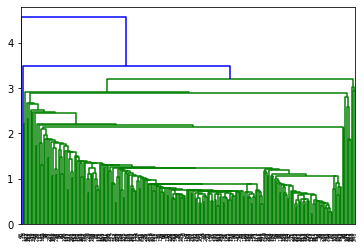

In [521]:
# single linkage
mergings = linkage(players_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

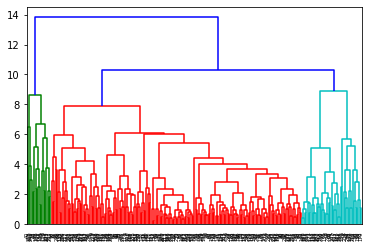

In [522]:
# complete linkage
mergings = linkage(players_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

## Hierarchical clustering

In [523]:
# Perform hierarchical clustering based on the input parameters
def hierarchical_clustering(linkage_method, linkage_metric, num_clusters,input_df,output_df,output_col):
    mergings = linkage(input_df, method=linkage_method, metric=linkage_metric)
    cluster_labels = cut_tree(mergings, n_clusters=num_clusters).reshape(-1, )
    # assign cluster labels
    output_df[output_col] = cluster_labels
    return mergings

In [524]:
# # Linkage method could be single, complete, average, weighted, centroid, median, ward
# # Refer to: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

# mergings = hierarchical_clustering(linkage_method = "complete", linkage_metric = "euclidean", num_clusters = NUM_CLUSTERS, input_df = players_scaled[ALL_COLUMN_NAMES], output_df = players, output_col = "cluster_hier")
# dendrogram(mergings)
# plt.show()

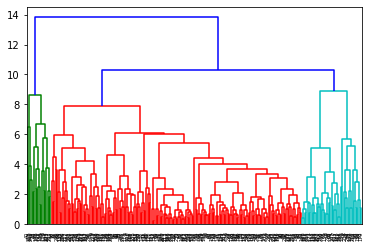

,name,cluster_hier
0,Yuvraj Singh,0
1,BB McCullum,0
2,M Vijay,0
188,Z Khan,1
189,YS Chahal,1
190,Sandeep Sharma,1
217,RA Jadeja,2
218,PP Chawla,2
219,Harbhajan Singh,2
233,RG Sharma,3


In [525]:
# New output column to create for the cluster label
hier_label = 'cluster_hier'


# Hierarchical clustering
# Linkage method could be single, complete, average, weighted, centroid, median, ward
# Refer to: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

mergings = hierarchical_clustering(linkage_method = "complete", linkage_metric = "euclidean", num_clusters = NUM_CLUSTERS, input_df = players_scaled[ALL_COLUMN_NAMES], output_df = players, output_col = "cluster_hier")
 
# Plot the dendogram
dendrogram(mergings)
plt.show()

# View few entries from each cluster
groupby_cluster(hier_label,3)

In [526]:
# # Create the cluster labels
# cluster_labels = cut_tree(mergings, n_clusters=NUM_CLUSTERS).reshape(-1, )# assign cluster labels
# players['cluster_hier'] = cluster_labels
# groupby_cluster("cluster_hier",2)


-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



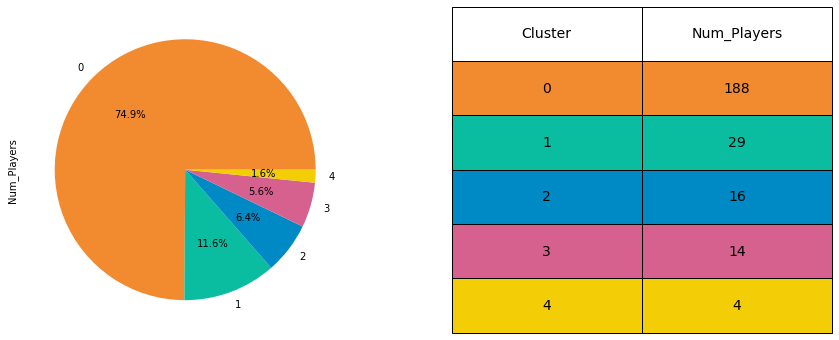

In [527]:
# View the summary of the clustering
clustering_summary(hier_label)

In [528]:
clustering_data(hier_label)


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



,0,1,2,3,4
0,Yuvraj Singh,KV Sharma,RA Jadeja,RG Sharma,YK Pathan
1,BB McCullum,MG Johnson,DJ Bravo,SK Raina,KA Pollard
2,M Vijay,RP Singh,Harbhajan Singh,V Kohli,SR Watson
3,V Sehwag,SK Warne,IK Pathan,RV Uthappa,CH Gayle
4,SV Samson,Z Khan,PP Chawla,MS Dhoni,
5,WP Saha,MM Sharma,AR Patel,KD Karthik,
6,JH Kallis,Sandeep Sharma,JA Morkel,S Dhawan,
7,NV Ojha,DS Kulkarni,SP Narine,AB de Villiers,
8,Mandeep Singh,MJ McClenaghan,P Kumar,G Gambhir,
9,DR Smith,PP Ojha,R Ashwin,AT Rayudu,


#  DBScan Clustering

In [529]:
# Perform density clustering based on the input parameters
def dbscan_clustering(epsilon, minimum_samples,input_df,output_df,output_col):
    # Compute DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit(input_df)
    labels = db.labels_

    # assign cluster labels
    output_df[output_col] = labels
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    #print('Estimated number of clusters: %d' % n_clusters_)
    #print('Estimated number of noise points: %d' % n_noise_)

In [530]:
# New output column to create for the cluster label
dbscan_label = 'cluster_dbscan'

# DBSCAN clustering
dbscan_clustering(0.9,3,players_scaled[ALL_COLUMN_NAMES],players,dbscan_label)

# View few entries from each cluster
groupby_cluster(dbscan_label,3)

,name,cluster_dbscan
0,RG Sharma,-1
1,SK Raina,-1
2,V Kohli,-1
105,Y Venugopal Rao,0
106,MC Henriques,0
107,M Kartik,0
192,Ishan Kishan,1
193,M Vohra,1
194,CA Lynn,1
233,LRPL Taylor,2



-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



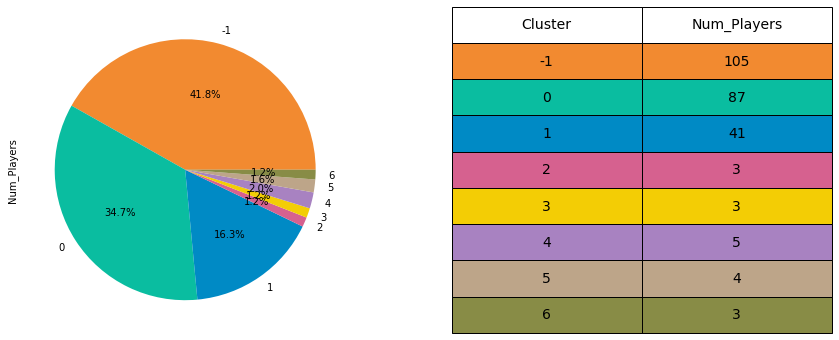

In [531]:

# View the summary of the clustering
clustering_summary(dbscan_label)

In [532]:
clustering_data(dbscan_label)


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



,-1,0,1,2,3,4,5,6
0,RG Sharma,Y Venugopal Rao,Ishan Kishan,LRPL Taylor,MM Sharma,KV Sharma,SS Tiwary,AB Dinda
1,SK Raina,AM Nayar,M Vohra,CL White,DS Kulkarni,MG Johnson,KK Nair,SK Trivedi
2,V Kohli,DJ Hooda,CA Lynn,RA Tripathi,I Sharma,SK Warne,S Badrinath,L Balaji
3,RV Uthappa,MC Henriques,MS Bisla,,,Mohammed Shami,EJG Morgan,
4,MS Dhoni,AD Mathews,PP Shaw,,,MM Patel,,
5,KD Karthik,TL Suman,Shubman Gill,,,,,
6,S Dhawan,M Manhas,HH Gibbs,,,,,
7,AB de Villiers,KP Pietersen,GJ Bailey,,,,,
8,YK Pathan,P Negi,ML Hayden,,,,,
9,G Gambhir,DT Christian,AP Tare,,,,,


In [533]:
#dbscan_clustering(0.8,5,players_scaled[ALL_COLUMN_NAMES],players,"cluster_dbscan")

In [534]:
# # Compute DBSCAN
# db = DBSCAN(eps=0.3, min_samples=5).fit(players_scaled)
# labels = db.labels_

# # assign cluster labels
# players['cluster_dbscan'] = labels


In [535]:
# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)

In [536]:
# groupby_cluster("cluster_dbscan",5)

# Comparing clustering results

In [537]:
print(f"K-means clustering with k={NUM_CLUSTERS}")
display(players['cluster_kmeans'].value_counts())
print(f"\nHierarchical clustering with k={NUM_CLUSTERS}")
display(players['cluster_hier'].value_counts())
print(f"\nDBScan clustering")
display(players['cluster_dbscan'].value_counts())

K-means clustering with k=5


0    105
1     50
4     41
3     39
2     16
Name: cluster_kmeans, dtype: int64


Hierarchical clustering with k=5


0    188
1     29
2     16
3     14
4      4
Name: cluster_hier, dtype: int64


DBScan clustering


-1    105
 0     87
 1     41
 4      5
 5      4
 6      3
 3      3
 2      3
Name: cluster_dbscan, dtype: int64

# Plots

## Runs vs Wickets

In [538]:
# Plotly scatter plot
def plot_clusters(x,y,cluster_col,size):
    color_dict = dict(zip(players[cluster_col].sort_values().unique(),CLUSTER_COLORS))
    fig = px.scatter(players, x=x,   y=y, color=cluster_col,
                     size=size, hover_data=['name'], title = f'Scatter Plot: {x} vs {y}, Size = {size}', color_discrete_map=color_dict)
    fig.show()

In [539]:
plot_clusters('runs','wickets','cluster_kmeans','catches')

In [540]:
plot_clusters('runs','wickets','cluster_hier','catches')

In [541]:
plot_clusters('runs','wickets','cluster_dbscan','catches')

In [542]:
# # Plotly scatter plot
# fig = px.scatter(players, x="runs",   y="wickets", color="cluster_kmeans",
#                  size='catches', hover_data=['name'], title = 'Scatter Plot: Runs vs Wickets, Size = catches', color_discrete_sequence=px.colors.qualitative.Light24)
# fig.show()

# # color_discrete_sequence - https://plotly.com/python/discrete-color/

## Seaborn - scatter plots

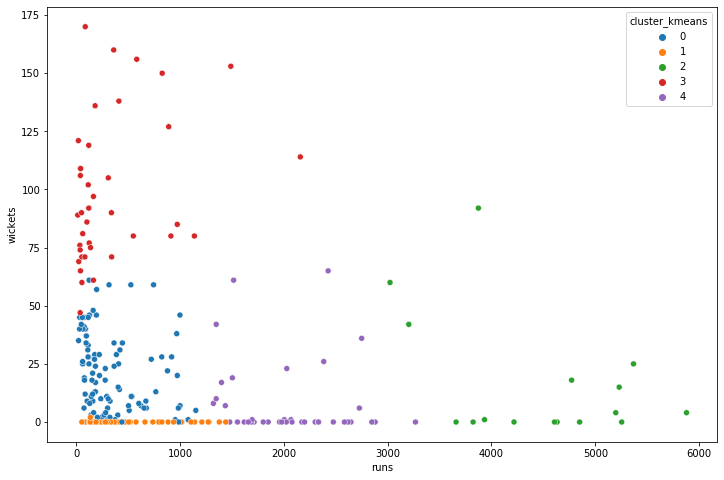

In [543]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_kmeans", data=players, palette="tab10")

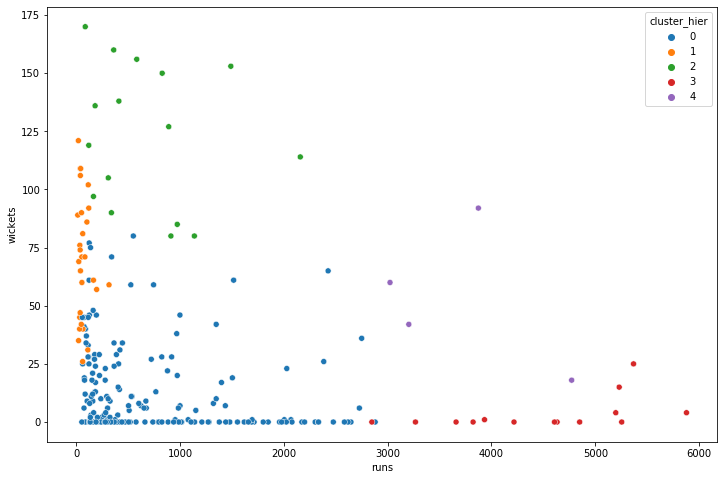

In [544]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_hier", data=players, palette="tab10")

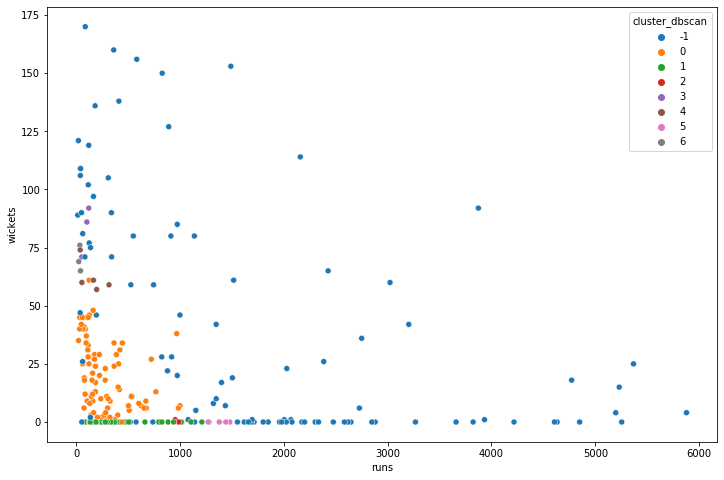

In [545]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_dbscan", data=players, palette="tab10")

## Runs vs catches

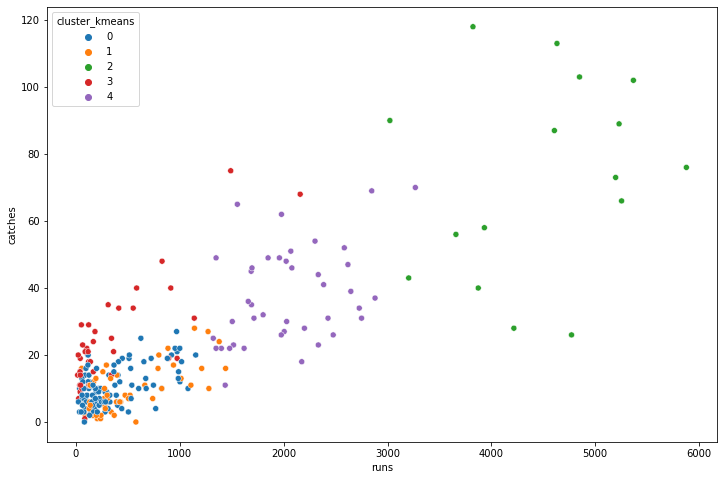

In [546]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="catches", hue="cluster_kmeans", data=players, palette="tab10")

# Only runs & wickets

In [547]:
cols = ['bat_average','bowl_econ']

In [548]:
# final model with k=3
kmeans = KMeans(n_clusters=NUM_CLUSTERS, max_iter=50)
kmeans.fit(players_scaled[cols])

# assign the label
players['cluster_kmeans_small'] = kmeans.labels_


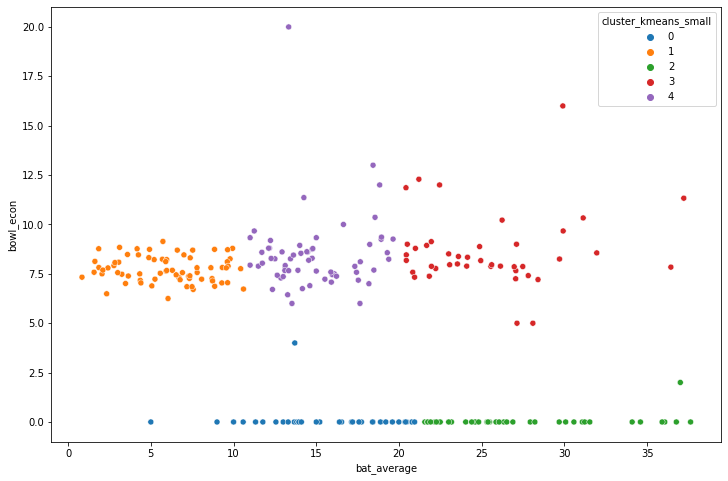

In [549]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="bat_average",   y="bowl_econ", hue="cluster_kmeans_small", data=players, palette="tab10")

In [550]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(players_scaled[cols])
labels = db.labels_

# assign cluster labels
players['cluster_dbscan_avgecon'] = labels

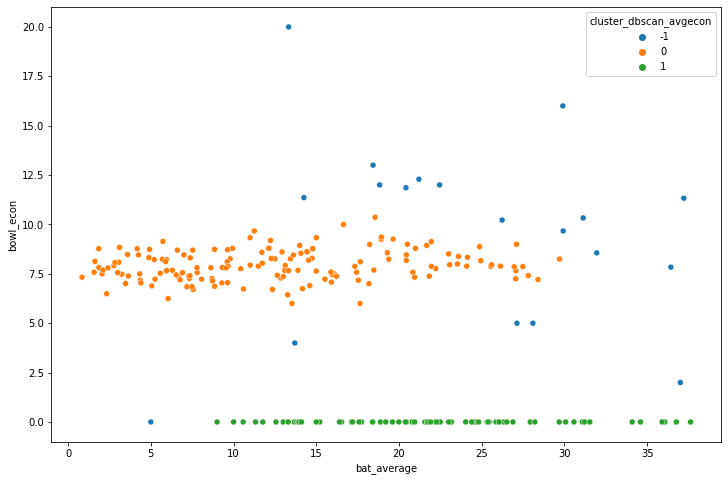

In [551]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="bat_average",   y="bowl_econ", hue="cluster_dbscan_avgecon", data=players, palette="tab10")

# References

In [552]:
# https://www.linkedin.com/pulse/ai-daily-life-clustering-cricket-players-ramachandran-s/
    

# WIDGETS

In [553]:
b_with_kvalue = True
config_layout = widgets.Layout(width= 'max-content', height='40px',justify_content='space-between',display='flex',
    flex_flow='column', align_items='stretch' )

widgets.IntSlider(
    value=5, min=2, max=10, step=1,
    description='No. of clusters:',
    disabled=not b_with_kvalue, layout=config_layout )

IntSlider(value=5, description='No. of clusters:', layout=Layout(align_items='stretch', display='flex', flex_f…

In [554]:
config_layout = widgets.Layout(width='auto', height='40px',
    display='flex',
    flex_flow='column',
    align_items='stretch') #set width and height

button = widgets.Button(
    description='Test button with some text.',
    disabled=False, 
    layout = config_layout
)        
display(button)

Button(description='Test button with some text.', layout=Layout(align_items='stretch', display='flex', flex_fl…

In [555]:
w_kvalue = widgets.BoundedIntText(
    value=5, min=2, max=10, step=1, description='', disabled=not b_with_kvalue,layout={'width': 'max-content'})

    
display(w_kvalue)

BoundedIntText(value=5, layout=Layout(width='max-content'), max=10, min=2)

In [556]:
w_ccolumns = widgets.SelectMultiple(options=ALL_COLUMN_NAMES, description='',
                                        value=CLUSTER_COLS,
                                         #layout={'width': 'max-content'}, 
                                        layout=widgets.Layout(display="flex", flex_flow='column'),
                                        style={'description_width': 'initial'}, disabled=False)


wid = widgets.SelectMultiple(
    options=ALL_COLUMN_NAMES,
    description='Groups',
    rows=len(ALL_COLUMN_NAMES),
    layout=widgets.Layout(width="flex"))
display(wid)

SelectMultiple(description='Groups', layout=Layout(width='flex'), options=('matches', 'balls_faced', 'innings'…

## MAIN WIDGET

In [654]:
# Default Values
CLUSTERING_TECHNIQUE = 'K-MEANS CLUSTERING'
CLUSTER_COLS = ALL_COLUMN_NAMES
CLUSTER_OUTPUT_COL = 'output_kmeans'
#NUM_CLUSTERS = 5
HIERARCHICAL_LINKAGE = 'complete'
#b_with_kvalue = True
b_kmeans_clustering = True
b_hier_clustering = False
b_dbscan_clustering = False

PLOT_X = 'runs'
PLOT_Y = 'wickets'
PLOT_SIZE = 'catches'

In [701]:
def display_clustering_description(cluster_technique):
    print(cluster_technique)
    print('-' * len(cluster_technique))
    if(cluster_technique == 'K-MEANS CLUSTERING'):
        print("- K-means is a centroid-based clustering algorithm")
        print("- It requires a pre-specified no. of clusters (k)")
        print("- The points are clustered based on the similarity (usually Euclidian Distance)")
        print("- Check out the 'Cluster Analysis' tab to find the optimal number of clusters")
        print("\n")
    elif(cluster_technique == 'HIERARCHICAL CLUSTERING'):
        print("- Hierarchical clustering builds nested clusters by merging points successively")
        print("- Hierarchical methods can be  either divisive or agglomerative")
        print("- The hierarchy of clusters is represented as a tree diagram known as dendrogram")
        print("- The linkage method defines the distance/similarity calculation")
        print("\n")
    elif(cluster_technique == 'DBSCAN CLUSTERING'):
        print("- DBSCAN: Density-Based Spatial Clustering of Applications with Noise")
        print("- DBSCAN groups together points that are closely packed together")
        print("- It marks points in low-density regions as outliers (noise)")
        print("- DBSCAN requires two key parameters: \n    1. Epsilon: radius to define the neighborhood around a point\n    2. Minimum Points: min neighbors within epsilon radius to form a dense region")
        print("\n")
    else:
        print("INVALID CLUSTERING TECHNIQUE!!")

In [704]:


############## Initialize Widgets ###################

w_ctechnique = widgets.RadioButtons(options=['K-MEANS CLUSTERING', 'HIERARCHICAL CLUSTERING', 'DBSCAN CLUSTERING'],
                                         value=CLUSTERING_TECHNIQUE, description='',
                                         layout={'width': 'max-content'}, 
                                         style={'description_width': 'initial'}, disabled=False)



# config_layout = widgets.Layout(  width='auto', height='40px',justify_content='space-between',display='flex',
#     flex_flow='column', align_items='stretch' )



# K-means Clustering Configurations


# No. of clusters
w_kvalue_kmeans = widgets.BoundedIntText(value=5, min=2, max=10, step=1, description='', disabled=not b_kmeans_clustering )

w_max_iter = widgets.BoundedIntText(
    value=50, min=2, max=1000, step=5, description='', disabled=not b_kmeans_clustering)

# Hierarchical Clustering Configurations
# No. of clusters
w_kvalue_hier = widgets.BoundedIntText(value=5, min=2, max=10, step=1, description='', disabled=not b_hier_clustering )

#Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
w_linkage = widgets.Dropdown(options=['single', 'complete', 'average','weighted', 'centroid', 'median','ward'],
                                         value=HIERARCHICAL_LINKAGE, description='',
                                         style={'description_width': 'initial'}, disabled=not b_hier_clustering)

# DBSCAN Clustering Configurations
w_epsilon = widgets.FloatSlider(
    value=0.9, min=0, max=5.0, step=0.1, description='',
    disabled=b_with_kvalue, continuous_update=False, orientation='horizontal',
    readout=True, readout_format='.1f',
    visibility = False
)

w_minpoints = widgets.IntSlider(
    value=5, min=2, max=20, step=1, description='', disabled=b_with_kvalue,
    visibility = False )


# Variables selection
multiselect_layout = widgets.Layout(width='40%')
w_ccolumns = widgets.SelectMultiple(options=ALL_COLUMN_NAMES, description='',
                                        value=CLUSTER_COLS,
                                        rows=len(ALL_COLUMN_NAMES),
                                        #layout=widgets.Layout(width="flex"),
                                        #layout={'width': 'max-content'}, 
                                        #layout=widgets.Layout(display="flex", flex_flow='column'),
                                    layout=widgets.Layout(border='solid', width="50%",display="flex", justify_content="flex-end"),
                                        style={'description_width': 'initial'}, disabled=False)


                                         
button_layout = widgets.Layout(display='flex', flex_flow='column', align_items='stretch', border='solid',
                               width='40%', height='40px')
wbtn_cluster_data = widgets.Button(description="CLUSTER PLAYERS", disabled=False, layout=button_layout,
                                     visibility="visible", button_style="success")

# Scatter plot selection


w_plot_x = widgets.Dropdown(options=ALL_COLUMN_NAMES,
                                         value=PLOT_X, description='',
                                         layout={'width': 'max-content'}, 
                                         style={'description_width': 'initial'}, disabled=False)

w_plot_y = widgets.Dropdown(options=ALL_COLUMN_NAMES,
                                         value=PLOT_Y, description='',
                                         layout={'width': 'max-content'}, 
                                         style={'description_width': 'initial'}, disabled=False)

w_plot_size = widgets.Dropdown(options=ALL_COLUMN_NAMES,
                                         value=PLOT_SIZE, description='',
                                         layout={'width': 'max-content'}, 
                                         style={'description_width': 'initial'}, disabled=False)
wbtn_plot_now = widgets.Button(description="PLOT NOW", disabled=False, layout=button_layout,
                                     visibility="visible", button_style="WARNING")

# Cluster Analysis
w_min_k = widgets.BoundedIntText(
    value=2, min=2, max=20, step=1, description='',layout={'width': 'max-content'}, disabled=False)


w_max_k = widgets.BoundedIntText(
    value=10, min=w_min_k.value, max=20, step=1, description='',layout={'width': 'max-content'}, disabled=False)

w_max_iter_analysis = widgets.BoundedIntText(
    value=50, min=2, max=1000, step=5, description='',layout={'width': 'max-content'}, disabled=False)

wbtn_elbow = widgets.Button(description="ELBOW METHOD", disabled=False, layout=button_layout,
                                     visibility="visible", button_style="WARNING")

wbtn_silhouette = widgets.Button(description="SILHOUETTE SCORE", disabled=False, layout=button_layout,
                                     visibility="visible", button_style="WARNING")

#wbtn_optimal_k = widgets.Button(description="FIND OPTIMAL K", disabled=False,
#                                       layout=button_layout,
#                                       visibility="visible", button_style="success")
output_clusters = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
output_plot = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
output_summary = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
output_all_stats = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
output_analysis = widgets.Output(layout=widgets.Layout(border='solid', width='100%')) 
output_desc = widgets.Output(layout=widgets.Layout( width="75%",display="flex", justify_content="flex-end"))    


############## Observe Widgets ###################
def create_clusters(): 
    global CLUSTER_OUTPUT_COL
    if(w_ctechnique.value == 'K-MEANS CLUSTERING'):
        CLUSTER_OUTPUT_COL = 'output_kmeans'
        kmeans_clustering(w_kvalue_kmeans.value,w_max_iter.value,players_scaled[CLUSTER_COLS],players,CLUSTER_OUTPUT_COL)
    elif(w_ctechnique.value == 'HIERARCHICAL CLUSTERING'):
        LINKAGE_METRIC = 'euclidean'  
        CLUSTER_OUTPUT_COL = 'output_hier'
        mergings = hierarchical_clustering(w_linkage.value, LINKAGE_METRIC, w_kvalue_hier.value, players_scaled[CLUSTER_COLS],players,CLUSTER_OUTPUT_COL)      
    elif(w_ctechnique.value == 'DBSCAN CLUSTERING'):
        CLUSTER_OUTPUT_COL = 'output_dbscan'
        dbscan_clustering(w_epsilon.value,w_minpoints.value,players_scaled[CLUSTER_COLS],players,CLUSTER_OUTPUT_COL)
    
    # Add prefix 'cluster' to cluster numbers
    players[CLUSTER_OUTPUT_COL]=players[CLUSTER_OUTPUT_COL].apply(lambda x: x if str(x).startswith('Cluster ')  else  f'Cluster {str(x)}')                                     
# Set values on observe


def update_output_description(cluster_technique):
    output_desc.clear_output()
    #print(cluster_technique)
    with output_desc:
        display_clustering_description(cluster_technique)
        
def set_cluster_technique( b):
    CLUSTERING_TECHNIQUE = w_ctechnique.value
    #b_with_kvalue = True 
    b_hier_clustering = False
    b_kmeans_clustering = False
    b_dbscan_clustering = False
    if(w_ctechnique.value == 'K-MEANS CLUSTERING'):
        b_kmeans_clustering = True
    elif(w_ctechnique.value == 'HIERARCHICAL CLUSTERING'):
        b_hier_clustering = True
    elif(w_ctechnique.value == 'DBSCAN CLUSTERING'):
        b_dbscan_clustering = True

    w_kvalue_kmeans.disabled = not b_kmeans_clustering
    w_max_iter.disabled = not b_kmeans_clustering
    w_kvalue_hier.disabled = not b_hier_clustering
    w_linkage.disabled = not b_hier_clustering
    w_epsilon.disabled = not b_dbscan_clustering
    w_minpoints.disabled = not b_dbscan_clustering
    
    update_output_description(CLUSTERING_TECHNIQUE)

def set_cluster_columns(b):
    global CLUSTER_COLS
    CLUSTER_COLS = list(w_ccolumns.value)
    
# def set_kvalue(b):
#     global NUM_CLUSTERS
#     NUM_CLUSTERS = w_kvalue.value
    
                                         
def on_cluster_players(b):
    tab.selected_index = 0 if tab.selected_index>3 else tab.selected_index
    
    output_clusters.clear_output()
    output_summary.clear_output()
    output_all_stats.clear_output()
    
    create_clusters()  
    with output_plot:
        on_plot_now(b) 
        #plot_clusters(w_plot_x.value,w_plot_size.value,CLUSTER_OUTPUT_COL,w_plot_size.value)
#         if(w_ctechnique.value == 'HIERARCHICAL CLUSTERING'):
#             print("Dendogram - Hierarchical Clustering")
#             dendrogram(mergings)
#             plt.show()

    with output_summary:
        clustering_summary(CLUSTER_OUTPUT_COL)
        
    with output_clusters:
        clustering_data(CLUSTER_OUTPUT_COL)   
        
    with output_all_stats:
        cluster_all_stats(CLUSTER_OUTPUT_COL)
        
        
def display_analysis_widgets():
    display(widgets.VBox([
                    widgets.HBox([widgets.Label("K Minimum : "),w_min_k,
                              widgets.Label("K Maximum : "),w_max_k,
                              widgets.Label("Max Iterations : "),w_max_iter_analysis]),
                    widgets.HBox([wbtn_elbow,
                              wbtn_silhouette])
        
            ]))

    
def on_plot_now(b):
    PLOT_X = w_plot_x.value
    PLOT_Y = w_plot_y.value
    PLOT_SIZE = w_plot_size.value
    output_plot.clear_output()
    with output_plot: 
        display(widgets.HBox([widgets.Label("X : "),w_plot_x,
                              widgets.Label("Y : "),w_plot_y,
                              widgets.Label("Size : "),w_plot_size,
                              wbtn_plot_now]))
        plot_clusters(PLOT_X,PLOT_Y,CLUSTER_OUTPUT_COL,PLOT_SIZE)

        
def on_elbow(b):
    output_analysis.clear_output()
    with output_analysis: 
        display_analysis_widgets()
        elbow_plot(w_min_k.value,w_max_k.value,w_max_iter_analysis.value)
        

def on_silhouette(b):
    output_analysis.clear_output()
    with output_analysis: 
        display_analysis_widgets()
        compute_silhouette_score(w_min_k.value,w_max_k.value,w_max_iter_analysis.value)
        
        
w_ctechnique.observe(set_cluster_technique, names='value')
w_kvalue.observe(set_kvalue, names='value') 

w_ccolumns.observe(set_cluster_columns, names='value') 

wbtn_cluster_data.on_click(on_cluster_players) 
wbtn_plot_now.on_click(on_plot_now) 
wbtn_elbow.on_click(on_elbow) 
wbtn_silhouette.on_click(on_silhouette) 

############## View Widgets ###################
config_item_layout = widgets.Layout(  display='flex', flex_flow='row',justify_content='space-between')
box_layout = widgets.Layout( display='flex', flex_flow='column',  border='solid 2px', align_items='stretch',width='50%')
box_players_layout = widgets.Layout( display='flex', flex_flow='column', align_items='center', border='solid 2px',width='50%')




def get_widget_label(label_text):
    #return widgets.Label(value = f"\(\color{{blue}} {{{label_text}}}\)")
    return widgets.HTML(value = f"<b><font color='black'>{label_text}</b>")

display(widgets.VBox([
    get_widget_label("ENTER CONFIGURATIONS"),
        widgets.HBox([
            widgets.VBox([get_widget_label("CLUSTERING TECHNIQUE:"), w_ctechnique],
                         layout=widgets.Layout(width='30%', display='flex', align_items='flex-start')), 
            output_desc,
            get_widget_label(""),
        ]),
     
        widgets.HBox([widgets.Label(" "),
         widgets.VBox([
                get_widget_label("K-MEANS CLUSTERING"),
                widgets.Box([widgets.Label("Number of Clusters:"), w_kvalue_kmeans], layout=config_item_layout),
                widgets.Box([widgets.Label("K-means Max Iterations:"),w_max_iter], layout=config_item_layout),
                get_widget_label("HIERARCHICAL CLUSTERING"),
                widgets.Box([widgets.Label("Number of Clusters:"), w_kvalue_hier], layout=config_item_layout),
                widgets.Box([widgets.Label("Hierarchical Linkage Method:"),w_linkage], layout=config_item_layout),
                get_widget_label("DBSCAN CLUSTERING"),
                widgets.Box([widgets.Label("DBSCAN Epsilon:"), w_epsilon], layout=config_item_layout),
                widgets.Box([widgets.Label("DBSCAN Minimum Points:"),w_minpoints], layout=config_item_layout)
         ],layout = box_layout),
         widgets.VBox([get_widget_label("SELECT VARIABLES TO CLUSTER ON:"),w_ccolumns],layout = box_players_layout)])
     ])) 
     

display(widgets.HBox([wbtn_cluster_data]))


# OUTPUT TABS
tab = widgets.Tab([output_plot, output_summary, output_clusters, output_all_stats,output_analysis])
tab.set_title(0, 'Scatter Plot')
tab.set_title(1, 'Clusters Summary')
tab.set_title(2, 'Players in Cluster')
tab.set_title(3, 'Player Stats')
tab.set_title(4, 'Cluster Analysis')
display(tab)
tab.selected_index = 4

with output_analysis:
    display_analysis_widgets()
    
update_output_description(CLUSTERING_TECHNIQUE)              
                  

# TESTING

In [625]:

form_item_layout = widgets.Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)

form_items = [
    widgets.Box([widgets.Label("Number of Clusters:"), w_kvalue], layout=form_item_layout),
    widgets.Box([widgets.Label("K-means Max Iterations:"),w_max_iter], layout=form_item_layout),
    widgets.Box([widgets.Label("Hierarchical Linkage Method:"),w_linkage], layout=form_item_layout),
    widgets.Box([widgets.Label("DBScan Epsilon:"), w_epsilon], layout=form_item_layout),
    widgets.Box([widgets.Label("DBScan Minimum Points:"),w_minpoints], layout=form_item_layout)
]

form = widgets.Box(form_items, layout=widgets.Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='50%'
))
form

Box(children=(Box(children=(Label(value='Number of Clusters:'), BoundedIntText(value=5, layout=Layout(width='m…

In [558]:
CLUSTER_COLORS = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#BDA589','#888C46',
                  '#36688D','#00743F','#0444BF','#A7414A','#1D65A6','red','green','blue','orange','pink','yellow']

In [559]:
clsum,cldf = clustering_summary("output_kmeans") 

KeyError: 'output_kmeans'

In [ ]:
# #clsum['Cluster'] = clsum.index
# clsum.insert(0, 'Cluster', clsum.index)
# #clsum.reset_index(inplace = True, drop = True)
# clsum

In [ ]:


fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
clsum['Num_Players'].plot.pie(colors = CLUSTER_COLORS)

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')


colors = []
num_columns = len(clsum.columns)
num_rows = len(clsum.index)
for i in range(num_rows):
    colors.append([CLUSTER_COLORS[i]] * num_columns)

mpl_table = ax2.table(cellText=clsum.values,cellColours=colors,
                     colLabels=clsum.columns,bbox=bbox,loc='center',cellLoc='center' )


#mpl_table = ax2.table(cellText = clsum.values, rowLabels = clsum.index, bbox=bbox, colLabels=clsum.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax =plt.subplots(1,1)
data=[[1,2,3],
      [5,6,7],
      [8,9,10]]
column_labels=["Column 1", "Column 2", "Column 3"]
df=pd.DataFrame(data,columns=column_labels)
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values,
        colLabels=df.columns,
        rowLabels=["A","B","C"],
        rowColours =["yellow"] * 3,  
        colColours =["yellow"] * 3,
        loc="center")

plt.show()

In [ ]:
#clsum.reset_index(inplace = True)
clsum.head()


In [ ]:
import matplotlib.pyplot as plt
# Prepare table
# Add a table at the bottom of the axes
colors = []
num_columns = len(clsum.columns)
num_rows = len(clsum.index)
for i in range(num_rows):
    colors.append([CLUSTER_COLORS[i]] * num_columns)
    
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=cell_text,cellColours=colors,
#                     colLabels=columns,loc='center')


the_table = ax.table(cellText=clsum.values,cellColours=colors,
                     colLabels=clsum.columns,bbox=bbox,loc='center',cellLoc='center' )

plt.show()

In [ ]:
CLUSTER_COLORS = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#36688D','#0444BF','#A7414A','#1D65A6','#BDA589','#00743F','#888C46','red','green','blue','orange','pink','yellow']

In [ ]:

def print_with_column_color_style(input_df):
    # Set some colour codes for the cluster columns
#     df_column_colors = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#36688D','#0444BF','#A7414A','#1D65A6','#BDA589','#00743F','#888C46','red','green','blue','orange','pink','yellow']

    col_bgcolor_dict = dict(zip(input_df.columns,['background-color:'+i for i in CLUSTER_COLORS]))
    def mycolor(x):
        return pd.DataFrame(col_bgcolor_dict,index=x.index,columns=x.columns)

    return input_df.style.apply(mycolor,axis=None)
    
    

In [ ]:
print_with_column_color_style(cldf.head())

In [ ]:
df.head()

In [ ]:
set_df_column_colors(cldf)

In [ ]:

def set_df_column_colors(input_df):
    # Set the colour codes for the columns
    df_column_colors = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#36688D','#0444BF','#A7414A','#1D65A6','#BDA589','#00743F','#888C46','red','green','blue','orange','pink','yellow'] 

    col_bgcolor_dict = dict(zip(input_df.columns,['background-color:'+i for i in df_column_colors]))
    
    def apply_color(x,bgcolor_dict):
        return pd.DataFrame(bgcolor_dict,index=x.index,columns=x.columns)

    input_df.style.apply(apply_color,col_bgcolor_dict,axis=None)

In [ ]:
CLUSTER_COLORS = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#36688D','#0444BF','#A7414A','#1D65A6','#BDA589','#00743F','#888C46','red','green','blue','orange','pink','yellow']